# Setup

Load packages

In [118]:
using CSV
using PyPlot
using LinearAlgebra
using Distributions
using Statistics
using Printf

# Bayesian linear regression

Load and plot data

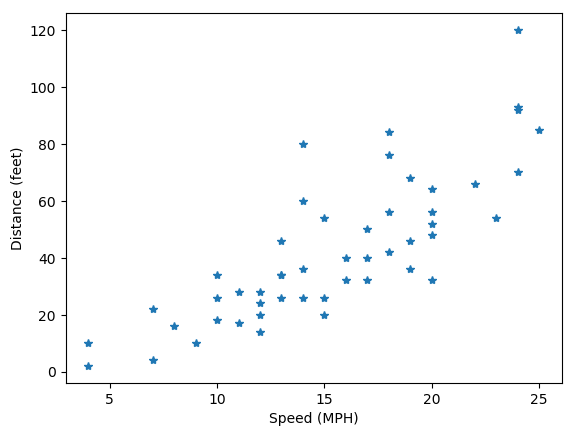

In [96]:
data = CSV.read("cars.csv") # Load the cars stopping distance dataset (see https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/cars.html)
x = convert(Array{Float64,1},data[:,2])
y = convert(Array{Float64,1},data[:,3])

PyPlot.figure()
PyPlot.plot(x,y, "*")
PyPlot.xlabel("Speed (MPH)")
PyPlot.ylabel("Distance (feet)");

LS estimations 

In [141]:
n = length(y) # set nbr of obs 

X = ones(n,2) # set design matrix 
X[:,2] = x

# compute LS estimations
β_hat_least_squares = inv(X'*X)*X'*y # est β'as
σ_hat_least_squares = sqrt((y'*y-β_hat_least_squares'*X'*y)/(n-2)) # est σ
β_hat_least_squares_std = σ_hat_least_squares*sqrt.([inv(X'*X)[1,1];inv(X'*X)[2,2]])

# compute conf int for β'as
conf_int_lower_bound = β_hat_least_squares - quantile(TDist(n-2), 0.975)*β_hat_least_squares_std 
conf_int_upper_bound = β_hat_least_squares + quantile(TDist(n-2), 0.975)*β_hat_least_squares_std

# compute conf int for σ (see https://www.overleaf.com/read/bfvqxqhsycgp)
Q_0 = sum((y.-mean(y)).^2) - sum((x.-mean(x)).*(y.-mean(y)))^2/sum((x.-mean(x)).^2)
conf_int_sigma = [sqrt(Q_0/quantile(Chisq(n-2),0.975)); sqrt(Q_0/quantile(Chisq(n-2),0.025))]


# print confidence intervals
@printf "Conf. int. β_1: [%.2f, %.2f]\n" conf_int_lower_bound[1] conf_int_upper_bound[1]
@printf "Conf. int. β_2: [%.2f, %.2f]\n" conf_int_lower_bound[2] conf_int_upper_bound[2]
@printf "Conf. int. σ: [%.2f, %.2f]\n" conf_int_sigma[1] conf_int_sigma[2]

Conf. int. β_1: [-31.17, -3.99]
Conf. int. β_2: [3.10, 4.77]
Conf. int. σ: [12.83, 19.21]


Specify the Bayesian model

In [142]:
# prior for β's: Normal(0,10)
μ_β_prior = 0;
σ_β_prior = 10;

# prior for σ: Gamma(2,3)
α_σ_prior = 2; # shape parameter
θ_σ_prior = 3; # scale parameter

Set-up functions for sampling from the posterior using the Metropolis-Hastings algorithm

In [145]:
# Evaluates the logarithm of the pdf for the joint prior.
function log_prior(θ::Vector)

  log_β_0_prior = log_normal_pdf(θ[1])
  log_β_1_prior = log_normal_pdf(θ[2])
  log_σ_prior = log_gamma_pdf(θ[3])

  return log_β_0_prior+log_β_1_prior+log_σ_prior

end


# Logarithm of the normal pdf.
function log_normal_pdf(x::Real)
  return -0.5*(x-μ_β_prior)^2/σ_β_prior^2
end

# Logarithm of the Gamma pdf.
function log_gamma_pdf(x::Real)
  if x <= 0
    return log(0)
  else
    return (α_σ_prior-1)*log(x)-x/θ_σ_prior
  end
end

# Log-likelihood for the simple linear model.
function loglik(y::Vector, x::Vector, θ::Vector)

  n = length(y)
  loglik = -n*0.5*log(θ[3]^2)

  for i = 1:n
    loglik += -0.5*(y[i]-θ[1]-θ[2]*x[i])^2/θ[3]^2
  end

  return loglik

end


# Runs the Metropolis-Hastings algorithm.
function MH(y::Vector, x::Vector, nbr_iter::Int, σ_mh::Real, θ_0::Vector, print_interval::Int=500)

  # pre-allocate matrices
  chain = zeros(length(θ_0), nbr_iter)
  loglik_vec = zeros(nbr_iter)
  accept_vec = zeros(nbr_iter)

  # set start values
  chain[:,1] = θ_0
  loglik_vec[1] = loglik(y,x,chain[:,1])

  # print start
  @printf "Starting Metropolis-Hastings\n"



  for i = 2:nbr_iter

    # print info
    if mod(i-1,print_interval) == 0
      # print progress
      @printf "Percentage done: %.2f\n" 100*(i-1)/nbr_iter
      # print current acceptance rate
      @printf "Acceptance rate on iteration %d to %d is %.4f\n" i-print_interval i-1  sum(accept_vec[i-print_interval:i-1])/( i-1 - (i-print_interval) )
    end

    # random walk proposal
    θ_proposal = chain[:,i-1] + rand(Normal(0,1),length(θ_0))*σ_mh

    # loglik for proposal
    loglik_proposal = loglik(y,x,θ_proposal)

    # compute logarithm of accaptance probability
    α_log = loglik_proposal + log_prior(θ_proposal) - (loglik(y,x,chain[:,i-1])+ log_prior(chain[:,i-1]))

    # generate log random number
    u_log = log(rand())

    # compute accaptance decision
    accept = u_log < α_log

    # update chain
    if accept
      chain[:,i] = θ_proposal
      loglik_vec[i] = loglik_proposal
      accept_vec[i] = 1
    else
      chain[:,i] = chain[:,i-1]
      loglik_vec[i] = loglik_vec[i-1]
    end

  end

  # print info
  @printf "Ending Metropolis-Hastings\n"
  return chain, loglik_vec, accept_vec

end

MH (generic function with 2 methods)

In [76]:
conf_int_upper_bound

2-element Array{Float64,1}:
 -3.981
  4.768